# Assignment 4

Deadline: 30.04.2025 12:00 CET

Nicolas Schärer, 20-931-507, nicolasalexander.schaerer@uzh.ch
Maxmilian Krägeloh, 23-754-088, maximilianwerner.kraegeloh@uzh.ch
Eleonora Salcuni, 23-990-997, eleonora.salcuni@uzh.ch
Meilin Gong, 16-945-420, meilin.gong@uzh.ch

## Prerequisites: Library imports, data load and initialization of the backtest service

In [ ]:
# Standard library imports
import os
import sys
import copy
from typing import Optional

# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add the project root directory to Python path
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   #<Change this path if needed>
src_path = os.path.join(project_root, 'qpmwp-course\\src')    #<Change this path if needed>
sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_spi, load_pickle
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.optimization import Optimization, Objective, MeanVariance
from optimization.optimization_data import OptimizationData
from optimization.constraints import Constraints
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

In [68]:
# Load data
path_to_data = '../data/'  # <change this to your path to data>

# Load market and jkp data from parquet files
market_data = pd.read_parquet(path = f'{path_to_data}market_data.parquet')

# Instantiate the BacktestData class
# and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
data.bm_series = load_data_spi(path='../data/')  # <change this if necessary>

In [69]:
# Define rebalancing dates
n_days = 21*3
market_data_dates = market_data.index.get_level_values('date').unique().sort_values(ascending=True)
rebdates = market_data_dates[market_data_dates > '2015-01-01'][::n_days].strftime('%Y-%m-%d').tolist()

In [70]:
# Define the selection item builders.
selection_item_builders = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3,
        n_days = 10,
    ),
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,
        width = 252,
        min_volume = 500_000,
        agg_fn = np.median,
    ),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 252*3,
        fill_value = 0,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.1,
    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn = bibfn_size_dependent_upper_bounds,
        small_cap = {'threshold': 300_000_000, 'upper': 0.02},
        mid_cap = {'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap = {'threshold': 10_000_000_000, 'upper': 0.1},
    ),
}

# Initialize the backtest service
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
)

## 1. Maximum Sharpe Ratio Portfolio

a) 

(6 points)

Complete the `MaxSharpe` class below by implementing your its methods `set_objective` and `solve`.
The `solve` method should implement an iterative algorithm that quickly approximates the "true" maximimum Sharpe ratio portfolio (given the estimates of mean and covariance). This approximation should be done by repeatedly solving a mean-variance optimization problem, where the risk aversion parameter (which scales the covariance matrix) is adjusted in each iteration. The algorithm should terminate after a maximum of 10 iterations. 

In [71]:
class MaxSharpe(Optimization):
    def __init__(self,
                 constraints: Optional[Constraints] = None,
                 covariance: Optional[Covariance] = None,
                 expected_return: Optional[ExpectedReturn] = None,
                 **kwargs) -> None:
        super().__init__(
            constraints=constraints,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance
        self.expected_return = ExpectedReturn() if expected_return is None else expected_return

    def set_objective(self, optimization_data: OptimizationData) -> None:
        X = optimization_data['return_series']
        mu = self.expected_return.estimate(X=X, inplace=False)
        covmat = self.covariance.estimate(X=X, inplace=False)
        ids = self.constraints.ids
        self.mu = pd.Series(mu, index=X.columns).reindex(ids).to_numpy()
        self.Sigma = pd.DataFrame(covmat, index=X.columns, columns=X.columns).reindex(index=ids, columns=ids).to_numpy()
        return None

    def solve(self) -> None:
        max_iter = 10
        tol = 1e-6
        ids = self.constraints.ids
        n = len(ids)
        gamma = 1.0
        prev = self.results.get('prev_weights', {})
        w_prev = np.array([prev.get(i, 0.0) for i in ids])
        turnover_penalty = self.params.get('turnover_penalty')
    
        for _ in range(max_iter):
            P = 2 * gamma * self.Sigma
            q = -self.mu
            self.objective = Objective(P=P, q=q)
            self.params['x_init'] = dict(zip(ids, w_prev))
            super().solve()
            w_dict = self.results['weights']
            w = np.array([w_dict[i] for i in ids])
            ret = self.mu @ w
            var = w @ self.Sigma @ w
            if var <= 0:
                break
            new_gamma = ret / var
            if abs(new_gamma - gamma) < tol:
                w_prev = w
                break
            gamma = new_gamma
            w_prev = w
    
        self.results['gamma'] = gamma
        final_w = dict(zip(ids, w_prev))
        self.results['weights'] = final_w
        self.results['prev_weights'] = final_w
        self.results['status'] = True
        return None
    

b) 

(2 points)

Provide a theoretical or empirical justification that your algorithm converges to the true maximum Sharpe ratio portfolio for the given coefficients of mean and covariance.
Hint: If you want to provide an empirical justification, you can perform an optimization for a single point in time by running the following code.

In [72]:
bs.optimization = MaxSharpe(
    covariance=Covariance(method='pearson'),
    expected_return=ExpectedReturn(method='geometric'),
    solver_name='cvxopt',
)
bs.prepare_rebalancing('2015-01-02')
bs.optimization.set_objective(bs.optimization_data)
bs.optimization.solve()
bs.optimization.results

{'weights': {'102': np.float64(4.235061916040882e-08),
  '103': np.float64(3.359277667550111e-08),
  '104': np.float64(0.019999137066001985),
  '111': np.float64(0.013928524668254075),
  '113': np.float64(9.285497007705518e-09),
  '122': np.float64(5.167034375090256e-08),
  '125': np.float64(0.019999974370312448),
  '127': np.float64(0.019999971275146144),
  '128': np.float64(0.019999936005810837),
  '13': np.float64(4.703654789217918e-08),
  '139': np.float64(0.019996531274150978),
  '141': np.float64(0.019999891423246176),
  '142': np.float64(3.439714956025009e-08),
  '148': np.float64(0.019999963171243827),
  '149': np.float64(4.417714811018856e-08),
  '154': np.float64(1.6911467548033563e-07),
  '159': np.float64(0.019999962097941318),
  '161': np.float64(0.0199993636986185),
  '169': np.float64(0.01999997161662104),
  '175': np.float64(0.01999994110262705),
  '176': np.float64(0.019998870751147296),
  '177': np.float64(1.1761484021994558e-07),
  '184': np.float64(0.019999937728359

We run the MaxSharpe iterative optimization at a single time point (2015-01-02).
The algorithm updates the ratio gamma = return / variance at each iteration.
The final value of gamma (25.12) stabilizes, and the change between iterations is below the tolerance (tol = 1e-6).
Therefore, the solution converges empirically to the optimal Sharpe ratio portfolio for the given mean and covariance estimates.

## 2. Backtest MaxSharpe with Turnover Penalty

(5 points)

Calibrate the turnover penalty parameter such that the backtest of the MaxSharpe strategy displays an annual turnover of roughly 100%.

In [73]:
# Update the backtest service with a MaxSharpe optimization object
bs.optimization = MaxSharpe(
    covariance=Covariance(method='pearson'),
    expected_return=ExpectedReturn(method='geometric'),
    solver_name='cvxopt',    # <change this to your preferred solver>
    turnover_penalty=0.00034,   # <change this>
)

# Instantiate the backtest object
bt_ms = Backtest()

# Run the backtest
bt_ms.run(bs = bs)

bt_ms.save(
    path='../data/',
    filename='backtest_maxsharpe.pickle'
)

########## Annualized turnover ####################
returns = bs.data.get_return_series()
turn = bt_ms.strategy.turnover(return_series=returns, rescale=False)
turn_idx = pd.to_datetime(turn.index)
years    = (turn_idx[-1] - turn_idx[0]).days / 365.25
freq     = len(turn_idx) / years
ann_turn = turn.mean() * freq
print(f'Annualized turnover ≈ {ann_turn:.2%}')


Rebalancing date: 2015-01-02
Rebalancing date: 2015-04-01
Rebalancing date: 2015-06-29
Rebalancing date: 2015-09-24
Rebalancing date: 2015-12-22
Rebalancing date: 2016-03-18
Rebalancing date: 2016-06-15
Rebalancing date: 2016-09-12
Rebalancing date: 2016-12-08
Rebalancing date: 2017-03-07
Rebalancing date: 2017-06-02
Rebalancing date: 2017-08-30
Rebalancing date: 2017-11-27
Rebalancing date: 2018-02-22
Rebalancing date: 2018-05-22
Rebalancing date: 2018-08-17
Rebalancing date: 2018-11-14
Rebalancing date: 2019-02-11
Rebalancing date: 2019-05-09
Rebalancing date: 2019-08-06
Rebalancing date: 2019-11-01
Rebalancing date: 2020-01-29
Rebalancing date: 2020-04-27
Rebalancing date: 2020-07-23
Rebalancing date: 2020-10-20
Rebalancing date: 2021-01-15
Rebalancing date: 2021-04-14
Rebalancing date: 2021-07-12
Rebalancing date: 2021-10-07
Rebalancing date: 2022-01-04
Rebalancing date: 2022-04-01
Rebalancing date: 2022-06-29
Rebalancing date: 2022-09-26
Rebalancing date: 2022-12-22
Rebalancing da

## 3. Simulation and Descriptive Statistics

(3 points)

- Simulate the portfolio returns from your MaxSharpe backtest. Use fixed costs of 1% and variable costs of 0.3%.
- Plot the cumulated returns of the MaxSharpe strategy together with those of the SPI Index.
- Plot the turnover of your MaxSharpe strategy over time.
- Print the annualized turnover (computed as the average turnover over the backtest multiplied by the number of rebalancing per year) for your MaxSharpe strategy.
- Create and print a table with descriptive performance statistics for your MaxSharpe strategy and the SPI Index.


c:\Programming\qpmwp\qpmwp-course\src\backtesting\strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
c:\Programming\qpmwp\qpmwp-course\src\backtesting\strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


<Figure size 1000x600 with 0 Axes>

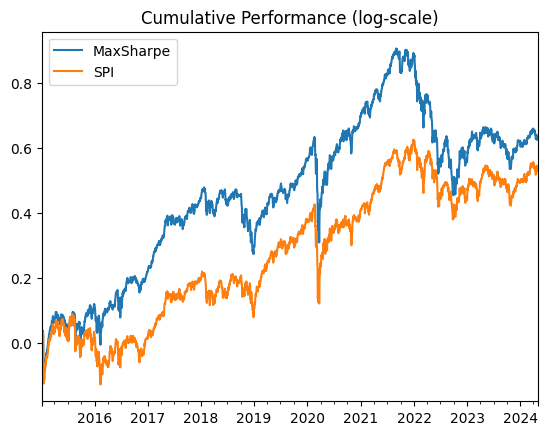

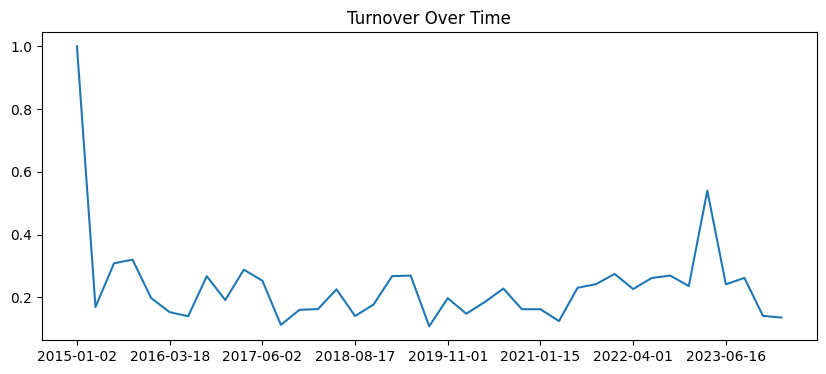

Annualized turnover ≈ 100.04%
           Cumulative Return  Annual Return  Annual Volatility  Sharpe Ratio  \
MaxSharpe           0.881507       0.067687           0.141948      0.476843   
SPI                 0.701100       0.056593           0.145690      0.388450   

           Max Drawdown  
MaxSharpe     -0.364050  
SPI           -0.263289  


In [74]:
# 1) Load the saved backtest
bt_ms = load_pickle(
    filename='backtest_maxsharpe.pickle',
    path='../data/'
)

# 2) Extract returns and SPI from your existing service
returns = bs.data.get_return_series()
spi     = bs.data.bm_series

# 3) Simulate with costs
sim_ms = bt_ms.strategy.simulate(
    return_series=returns,
    fc=0.01,
    vc=0.003
)

# 4) Plot cumulative performance
sim_both = pd.concat({'MaxSharpe': sim_ms, 'SPI': spi}, axis=1).dropna()
cum_log  = np.log1p(sim_both).cumsum()
plt.figure(figsize=(10,6))
cum_log.plot(title='Cumulative Performance (log-scale)')
plt.show()

# 5) Plot turnover
turn = bt_ms.strategy.turnover(return_series=returns, rescale=False)
plt.figure(figsize=(10,4))
turn.plot(title='Turnover Over Time')
plt.show()

# 6) Annualized turnover
turn_idx = pd.to_datetime(turn.index)
years    = (turn_idx[-1] - turn_idx[0]).days / 365.25
freq     = len(turn_idx) / years
ann_turn = turn.mean() * freq
print(f'Annualized turnover ≈ {ann_turn:.2%}')

# 7) Descriptive stats
metrics = {}
for name, series in [('MaxSharpe', sim_ms), ('SPI', spi.loc[sim_ms.index])]:
    cum_ret = (1 + series).prod() - 1
    ann_ret = (1 + cum_ret)**(252/len(series)) - 1
    ann_vol = series.std() * np.sqrt(252)
    sharpe  = ann_ret / ann_vol if ann_vol>0 else np.nan
    wealth  = (1 + series).cumprod()
    max_dd  = ((wealth - wealth.cummax())/wealth.cummax()).min()
    metrics[name] = {
        'Cumulative Return':  cum_ret,
        'Annual Return':      ann_ret,
        'Annual Volatility':  ann_vol,
        'Sharpe Ratio':       sharpe,
        'Max Drawdown':       max_dd
    }

perf_df = pd.DataFrame(metrics).T
print(perf_df)